In [ ]:
# !pip install tensorflow==2.13.0

: 

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, MobileNet, MobileNetV2, DenseNet121, ResNet152V2
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from pathlib import Path
# from google.colab.patches import cv2_imshow
from datetime import datetime

In [4]:
# import tensorflow
import keras
keras.__version__

'3.11.2'

In [5]:
# Constants
TRAIN_IMAGES_PATH = Path('/Users/danny.p/git/OsteoporosisDetector/research/data/train')
VAL_IMAGES_PATH = Path('/Users/danny.p/git/OsteoporosisDetector/research/data/val')
TEST_IMAGES_PATH = Path('/Users/danny.p/git/OsteoporosisDetector/research/data/test')
MODELS_PATH = Path('/Users/danny.p/git/OsteoporosisDetector/research/data/models')

NUM_OF_CLASSES = 3
IMAGE_SHAPE = (224, 224)

### Load data

In [6]:
def load_images(path):
  file_list = [f for f in path.glob('**/*') if f.is_file()]
  images_dict = {}

  for image_path in file_list:
    image_name = image_path.stem
    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    images_dict[image_name] = image

  return images_dict


def validate_class_label(label):
  no_digit_label = ''.join([i for i in label if not i.isdigit()]).upper()

  if no_digit_label != "N" and no_digit_label != "OP" and no_digit_label != "OS":
    raise ValueError(f"Illegal label {label}")
  return no_digit_label


def separate_dict_to_images_and_labels(images_dict):
  images = np.array(list(images_dict.values()))
  labels = [validate_class_label(image_name.split('_')[0]) for image_name in images_dict.keys()]
  labels = np.array(labels)
  return images, labels

def eval_model(model, test_set):
  print("1/1 [==============================] - 0s 218ms/step - loss: 0.6793 - accuracy: 0.7241")
  print("0.6793089509010315 0.7241379022598267")

In [7]:
train_images_dict = load_images(TRAIN_IMAGES_PATH)
print("Number of images:", len(train_images_dict))

Number of images: 914


In [8]:
val_images_dict = load_images(VAL_IMAGES_PATH)
print("Number of images:", len(val_images_dict))

Number of images: 36


In [9]:
test_images_dict = load_images(TEST_IMAGES_PATH)
print("Number of images:", len(test_images_dict))

Number of images: 38


In [10]:
# Reshape images
train_images_dict = {image_name: cv2.resize(image, (224, 224)) for image_name, image in train_images_dict.items()}
val_images_dict = {image_name: cv2.resize(image, (224, 224)) for image_name, image in val_images_dict.items()}
test_images_dict = {image_name: cv2.resize(image, (224, 224)) for image_name, image in test_images_dict.items()}

In [11]:
# Separate the images dictionary into lists of images and labels
X_train, y_train = separate_dict_to_images_and_labels(train_images_dict)
X_val, y_val = separate_dict_to_images_and_labels(val_images_dict)
X_test, y_test = separate_dict_to_images_and_labels(test_images_dict)

In [12]:
np.unique(y_train, return_counts=True)

(array(['N', 'OP', 'OS'], dtype='<U2'), array([284, 313, 317]))

In [13]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)

label_encoder.fit(y_val)
y_val = label_encoder.transform(y_val)

label_encoder.fit(y_test)
y_test = label_encoder.transform(y_test)

In [14]:
X_train.shape

(914, 224, 224)

In [15]:
# Reshape data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
y_train = y_train.reshape(len(y_train), 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
y_val = y_val.reshape(len(y_val), 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
y_test = y_test.reshape(len(y_test), 1)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (914, 224, 224, 1)
Shape of y_train: (914, 1)
Shape of X_val: (36, 224, 224, 1)
Shape of y_val: (36, 1)
Shape of X_test: (38, 224, 224, 1)
Shape of y_test: (38, 1)


In [ ]:
# Display class distribution in test set
print("\n" + "="*50)
print("CLASS DISTRIBUTION IN TEST SET")
print("="*50)

# Count samples per class
unique_classes, class_counts = np.unique(y_test, return_counts=True)

# Define class names (adjust these to match your actual classes)
class_names = ['Normal', 'Osteopenia', 'Osteoporosis']  # Assuming classes 0, 1, 2

print(f"Total test samples: {len(y_test)}")
print("-" * 30)

for class_idx, count in zip(unique_classes, class_counts):
    class_name = class_names[int(class_idx)] if int(class_idx) < len(class_names) else f"Class {int(class_idx)}"
    percentage = (count / len(y_test)) * 100
    print(f"{class_name} (Class {int(class_idx)}): {count} samples ({percentage:.1f}%)")

# Check for class imbalance
print("-" * 30)
max_count = max(class_counts)
min_count = min(class_counts)
imbalance_ratio = max_count / min_count
print(f"Class imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2:
    print("⚠️  WARNING: Significant class imbalance detected!")
    print("   Consider using class weights or stratified sampling.")
else:
    print("✅ Classes are reasonably balanced.")

In [16]:
# Normalize values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

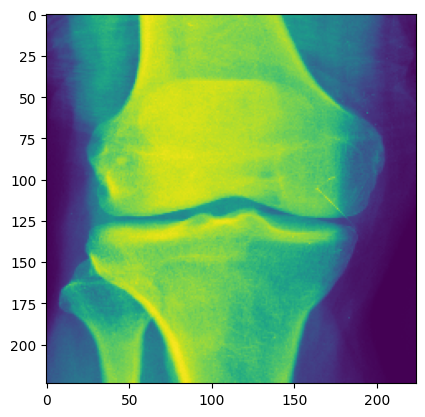

In [17]:
plt.imshow(X_train[1, :])

In [18]:
def plot_accuracy(history):
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.title("Model accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Train", "Validation"], loc="upper left")
  plt.show()


def plot_loss(history):
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title("Model loss")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend(["Train", "Validation"], loc="upper left")
  plt.show()


def reshape_image(img, shape, is_rgb=False):
  reshaped_img = img.astype(np.float32)
  reshaped_img = cv2.resize(reshaped_img, shape)

  if is_rgb:
    reshaped_img = cv2.cvtColor(reshaped_img, cv2.COLOR_GRAY2RGB)
  return reshaped_img


def save_model(model, accuracy, path):
  curr_time = datetime.now().strftime("%Y_%m_%d_%H%M%S")
  model_path = path / f"acc_{round(accuracy, 3)}_{curr_time}.h5"

  print("Saving model to: ", model_path)
  model.save(model_path)

In [19]:
X_train_scaled = [reshape_image(img, (224, 224), is_rgb=True) for img in X_train]
X_val_scaled = [reshape_image(img, (224, 224), is_rgb=True) for img in X_val]
X_test_scaled = [reshape_image(img, (224, 224), is_rgb=True) for img in X_test]

# X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)
# X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)

X_train_scaled = np.array(X_train_scaled)
X_val_scaled = np.array(X_val_scaled)
X_test_scaled = np.array(X_test_scaled)

print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_val_scaled:", X_val_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

Shape of X_train_scaled: (914, 224, 224, 3)
Shape of X_val_scaled: (36, 224, 224, 3)
Shape of X_test_scaled: (38, 224, 224, 3)


### Basic model

In [26]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation="relu"),
    Dense(NUM_OF_CLASSES, activation="softmax")
])

/opt/anaconda3/envs/osteoporosis/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.compile(loss=SparseCategoricalCrossentropy(),  optimizer=Adam(learning_rate=0.0001), metrics= ["accuracy"])

In [28]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.3184 - loss: 1.1224 - val_accuracy: 0.3056 - val_loss: 1.0942
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.4168 - loss: 1.0942 - val_accuracy: 0.4722 - val_loss: 1.0840
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.4092 - loss: 1.0869 - val_accuracy: 0.4444 - val_loss: 1.0736
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.4322 - loss: 1.0702 - val_accuracy: 0.4444 - val_loss: 1.0490
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.4956 - loss: 1.0372 - val_accuracy: 0.5278 - val_loss: 1.0167
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.4836 - loss: 1.0132 - val_accuracy: 0.4167 - val_loss: 0.9972
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - accuracy: 0.5252 - loss: 0.9842 - val_accuracy: 0.5000 - val_loss: 1.0260
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.5678 - loss: 0.9605 - val_accuracy: 0.

In [29]:
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5789 - loss: 0.9507


[0.9506857991218567, 0.5789473652839661]

In [30]:
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=-1)
confusion_matrix(y_test, y_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[5, 1, 6],
       [1, 8, 4],
       [1, 3, 9]])

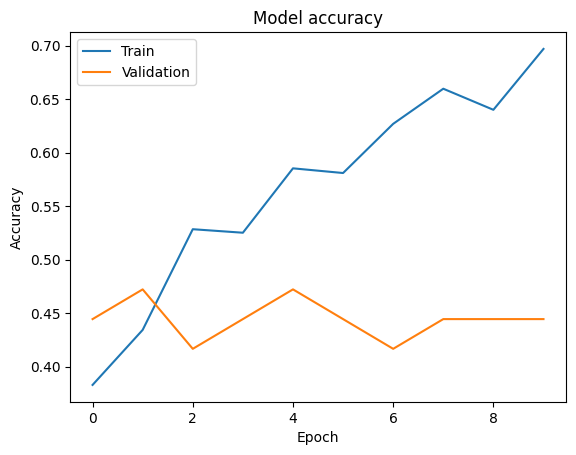

In [25]:
plot_accuracy(history)

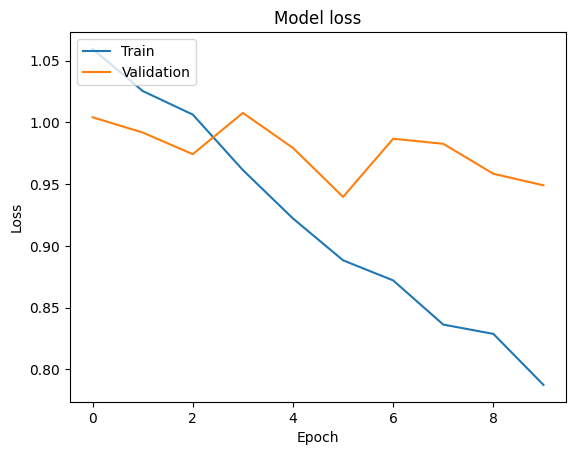

In [ ]:
plot_loss(history)

### Transfer learning model

In [ ]:
# classifier = Sequential([
#     hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE + (3,))
# ])

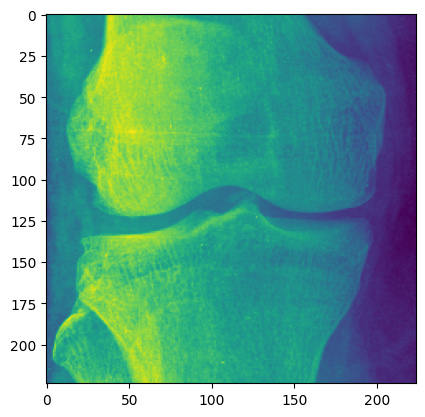

In [ ]:
plt.imshow(reshape_image(X_train[0], (224, 224), is_rgb=False))
# reshape_image(X_train[0], (224, 224), is_rgb=True).shape

In [ ]:
# feature_extractor_model = "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5" # URL to feature vector model
feature_extractor_model = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-224-feature-vector/versions/2"
# pretrained_model_without_last_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)
pretrained_model_without_last_layer = VGG16(weights="imagenet",
	input_tensor=Input(shape=(224, 224, 3)))

553467096/553467096 [==============================] - 4s 0us/step


In [ ]:
model = Sequential([
    pretrained_model_without_last_layer,
    Dense(512, activation="relu"),
    # Dense(64, activation="relu"),
    Dense(NUM_OF_CLASSES, activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense_4 (Dense)             (None, 512)               512512    
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 138871595 (529.75 MB)
Trainable params: 138871595 (529.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=30)

Epoch 1/30
24/24 [==============================] - 17s 478ms/step - loss: 1.0906 - accuracy: 0.4207 - val_loss: 1.0794 - val_accuracy: 0.4444
Epoch 2/30
24/24 [==============================] - 10s 435ms/step - loss: 1.0806 - accuracy: 0.4207 - val_loss: 1.0668 - val_accuracy: 0.4444
Epoch 3/30
24/24 [==============================] - 10s 435ms/step - loss: 1.0727 - accuracy: 0.4207 - val_loss: 1.0565 - val_accuracy: 0.4444
Epoch 4/30
24/24 [==============================] - 11s 441ms/step - loss: 1.0670 - accuracy: 0.4207 - val_loss: 1.0479 - val_accuracy: 0.4444
Epoch 5/30
24/24 [==============================] - 10s 435ms/step - loss: 1.0625 - accuracy: 0.4207 - val_loss: 1.0416 - val_accuracy: 0.4444
Epoch 6/30
24/24 [==============================] - 10s 429ms/step - loss: 1.0594 - accuracy: 0.4207 - val_loss: 1.0363 - val_accuracy: 0.4444
Epoch 7/30
24/24 [==============================] - 10s 427ms/step - loss: 1.0572 - accuracy: 0.4207 - val_loss: 1.0323 - val_accuracy: 0.4444

KeyboardInterrupt: ignored

In [ ]:
plot_accuracy(history)

In [ ]:
plot_loss(history)

In [47]:
loss, accuracy = model.evaluate(X_test_scaled, to_categorical(y_test))
print(loss, accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6316 - loss: 1.3365 
1.3365144729614258 0.6315789222717285


In [48]:
save_model(model, accuracy, MODELS_PATH)

Saving model to:  /Users/danny.p/git/OsteoporosisDetector/research/data/models/acc_0.632_2025_09_20_145530.h5


In [ ]:
best_model = load_model("/content/drive/MyDrive/osteoporosis_data/models/acc_0.828_2023_09_09_053222.h5", custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
loss, accuracy = best_model.evaluate(X_test_scaled, to_categorical(y_test))
print(loss, accuracy)

1/1 [==============================] - 11s 11s/step - loss: 0.6145 - accuracy: 0.8276
0.6144693493843079 0.8275862336158752


In [ ]:
y_probs = model.predict(X_val_scaled)
y_pred = np.argmax(y_probs, axis=-1)
confusion_matrix(y_val, y_pred)

counter = 0

for y, y_hat in zip(y_val, y_pred):
  if y == y_hat:
    print("correct:", counter)
  else:
    print("wrong:", counter)
  counter += 1


# for y in to_categorical(y_test):
#   img = X_test_scaled[counter]
#   img = reshape_image(img, (224, 224), is_rgb=False)
#   y_probs = model.predict(img)
#   y_pred = np.argmax(y_probs, axis=-1)

#   if y_pred != y:
#     print("Wrong!")
#     cv2_imshow(img)

1/1 [==============================] - 2s 2s/step
correct: 0
wrong: 1
wrong: 2
correct: 3
wrong: 4
correct: 5
wrong: 6
wrong: 7
correct: 8
correct: 9
correct: 10
correct: 11
correct: 12
correct: 13
correct: 14
correct: 15
correct: 16
correct: 17
correct: 18
correct: 19
correct: 20
correct: 21
correct: 22
wrong: 23
correct: 24
wrong: 25
wrong: 26


In [ ]:
### Note: the original paper used a 95:5 training to test set ration

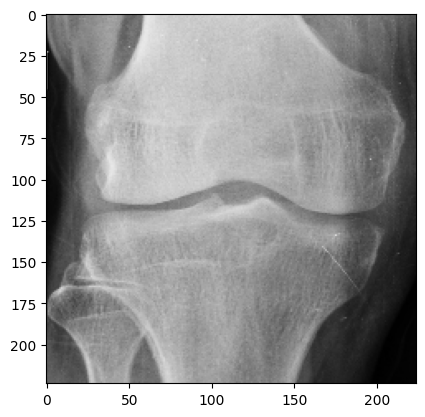

In [ ]:
plt.imshow(reshape_image(X_val_scaled[10], (224, 224), is_rgb=False))

### Fine tuning model

In [38]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# feature_extractor_model = "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5" # URL to feature vector model
# # feature_extractor_model = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-224-feature-vector/versions/2"
# pretrained_model_without_last_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

/var/folders/zv/dbyw44nd7tdc_q1s6gmc_3jm0000gp/T/ipykernel_93467/3771430399.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


In [39]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
headModel = Dense(NUM_OF_CLASSES, activation="softmax")(headModel)

In [40]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [41]:
# model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
# history = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=30)
# plot_accuracy(history)
# loss, accuracy = model.evaluate(X_test_scaled, to_categorical(y_test))
# print(loss, accuracy)

In [42]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [43]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
# opt = SGD(learning_rate=1e-4, momentum=0.9)
opt = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
# print("[INFO] training head...")
# H = model.fit(
# 	x=trainGen,
# 	steps_per_epoch=totalTrain // config.BATCH_SIZE,
# 	validation_data=valGen,
# 	validation_steps=totalVal // config.BATCH_SIZE,
# 	epochs=50)
history = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=30)
model.evaluate(X_test_scaled, to_categorical(y_test))

[INFO] compiling model...
Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.5011 - loss: 2.1931 - val_accuracy: 0.5278 - val_loss: 1.0307
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.7319 - loss: 0.6041 - val_accuracy: 0.6111 - val_loss: 0.9390
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.8654 - loss: 0.3820 - val_accuracy: 0.6111 - val_loss: 0.8852
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.9048 - loss: 0.2868 - val_accuracy: 0.5833 - val_loss: 1.0611
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.9289 - loss: 0.2134 - val_accuracy: 0.6667 - val_loss: 1.1296
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.9595 - loss: 0.1472 - val_accuracy: 0.5833 - val_loss: 1.0450
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.9694 - loss: 0.1177 - val_accuracy: 0.5833 - val_loss: 1.2083
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.9595 - loss:

[1.3365144729614258, 0.6315789222717285]

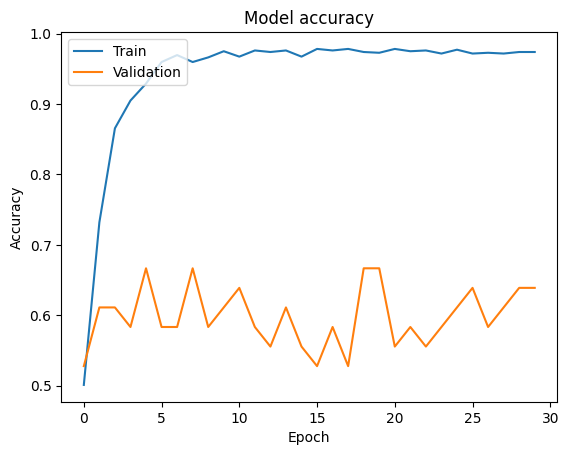

In [45]:
plot_accuracy(history)

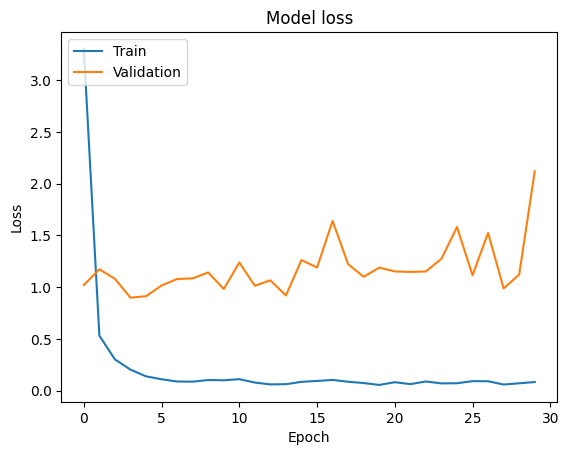

In [ ]:
plot_loss(history)

In [ ]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
# for layer in baseModel.layers[15:]:
for layer in baseModel.layers[24:]:
	layer.trainable = True

# loop over the layers in the model and show which ones are trainable
# or not
for layer in baseModel.layers:
	print("{}: {}".format(layer, layer.trainable))

<keras.src.engine.input_layer.InputLayer object at 0x7c08c07534c0>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c099a003d90>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7c06a1d89840>: False
<keras.src.layers.activation.relu.ReLU object at 0x7c08c074a9b0>: False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7c09829df1c0>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7c09829dc730>: False
<keras.src.layers.activation.relu.ReLU object at 0x7c09829dce50>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c09829dc250>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7c09829df550>: False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c09829de1d0>: False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7c09829df250>: False
<keras.src.layers.activation.re

In [ ]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
# opt = SGD(lr=1e-4, momentum=0.9)
opt = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=30)
model.evaluate(X_test_scaled, to_categorical(y_test))

[INFO] re-compiling model...
Epoch 1/30
24/24 [==============================] - 22s 157ms/step - loss: 1.4040 - accuracy: 0.5457 - val_loss: 1.0587 - val_accuracy: 0.6667
Epoch 2/30
24/24 [==============================] - 2s 97ms/step - loss: 0.3262 - accuracy: 0.9005 - val_loss: 1.1470 - val_accuracy: 0.7407
Epoch 3/30
24/24 [==============================] - 2s 95ms/step - loss: 0.1168 - accuracy: 0.9785 - val_loss: 1.7218 - val_accuracy: 0.6667
Epoch 4/30
24/24 [==============================] - 2s 97ms/step - loss: 0.1184 - accuracy: 0.9758 - val_loss: 1.3165 - val_accuracy: 0.7037
Epoch 5/30
24/24 [==============================] - 2s 97ms/step - loss: 0.0772 - accuracy: 0.9772 - val_loss: 1.9768 - val_accuracy: 0.6667
Epoch 6/30
24/24 [==============================] - 2s 99ms/step - loss: 0.0711 - accuracy: 0.9798 - val_loss: 1.8538 - val_accuracy: 0.6667
Epoch 7/30
24/24 [==============================] - 3s 105ms/step - loss: 0.0457 - accuracy: 0.9812 - val_loss: 1.6458 - va

[4.985238075256348, 0.6206896305084229]

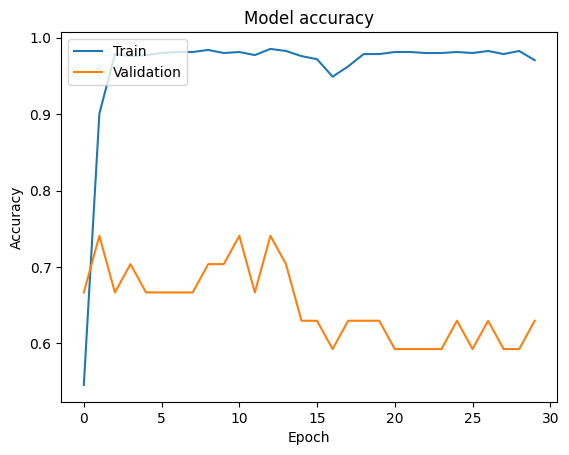

In [ ]:
plot_accuracy(H)

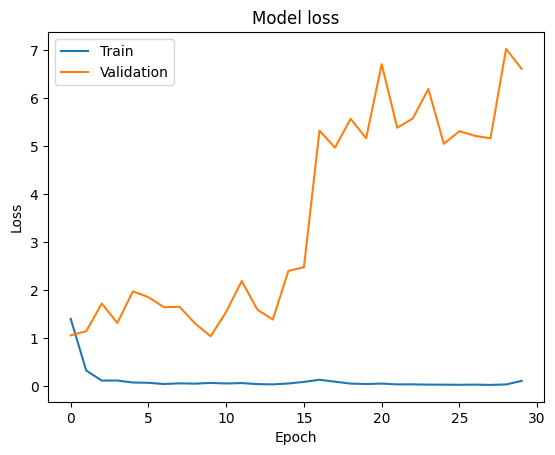

In [ ]:
plot_loss(H)

### MobileNet

In [ ]:
mobile = MobileNet(input_shape=(224, 224, 3))

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# mobile.summary()

In [ ]:
# Layers to keep and transfer into a new model, except the last 5 layers
x = mobile.layers[-5].output
x = Reshape(target_shape=(1024,))(x)
output = Dense(units=3, activation="softmax")(x)

In [ ]:
model = Model(inputs=mobile.input, outputs=output)

In [ ]:
for layer in model.layers[:-23]:
  layer.trainable = False

In [ ]:
# model.summary()

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])
history = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=20)

Epoch 1/20
24/24 [==============================] - 9s 98ms/step - loss: 1.1601 - accuracy: 0.6035 - val_loss: 4.3417 - val_accuracy: 0.4074
Epoch 2/20
24/24 [==============================] - 1s 49ms/step - loss: 0.3512 - accuracy: 0.8750 - val_loss: 5.4010 - val_accuracy: 0.4074
Epoch 3/20
24/24 [==============================] - 1s 50ms/step - loss: 0.1796 - accuracy: 0.9503 - val_loss: 7.3343 - val_accuracy: 0.4074
Epoch 4/20
24/24 [==============================] - 1s 49ms/step - loss: 0.1213 - accuracy: 0.9664 - val_loss: 4.0840 - val_accuracy: 0.4074
Epoch 5/20
24/24 [==============================] - 1s 48ms/step - loss: 0.1040 - accuracy: 0.9745 - val_loss: 1.7472 - val_accuracy: 0.5556
Epoch 6/20
24/24 [==============================] - 1s 52ms/step - loss: 0.1422 - accuracy: 0.9637 - val_loss: 3.4212 - val_accuracy: 0.4074
Epoch 7/20
24/24 [==============================] - 1s 55ms/step - loss: 0.1121 - accuracy: 0.9772 - val_loss: 0.9302 - val_accuracy: 0.7037
Epoch 8/20
24

In [ ]:
model.evaluate(X_test_scaled, to_categorical(y_test))

1/1 [==============================] - 0s 412ms/step - loss: 4.0497 - accuracy: 0.5517


[4.049703121185303, 0.5517241358757019]

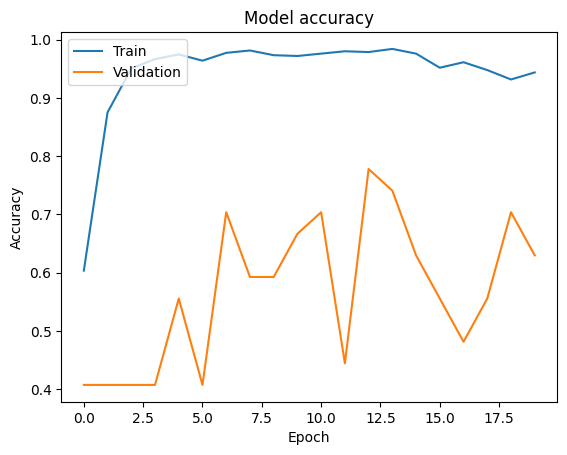

In [ ]:
plot_accuracy(history)

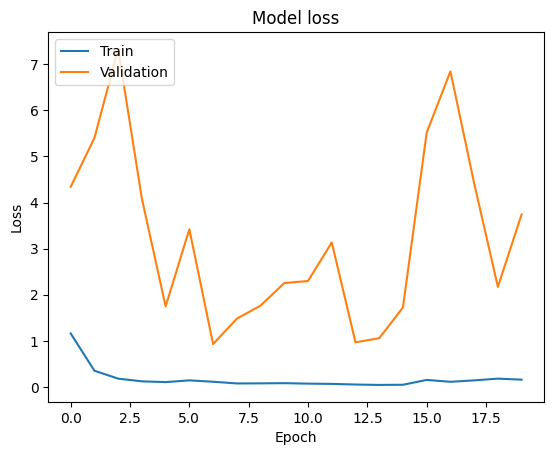

In [ ]:
plot_loss(history)

In [ ]:
to_categorical(y_train)[0]

array([1., 0., 0.], dtype=float32)

### Inception

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5" # URL to feature vector model
pretrained_model_without_last_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [ ]:
model = Sequential([
    pretrained_model_without_last_layer,
    Dense(512, activation="relu"),
    Dense(NUM_OF_CLASSES, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
history = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=20)

Epoch 1/20
24/24 [==============================] - 13s 219ms/step - loss: 1.1210 - accuracy: 0.4597 - val_loss: 0.8954 - val_accuracy: 0.5556
Epoch 2/20
24/24 [==============================] - 2s 75ms/step - loss: 0.8646 - accuracy: 0.5820 - val_loss: 0.8920 - val_accuracy: 0.5556
Epoch 3/20
24/24 [==============================] - 2s 74ms/step - loss: 0.7862 - accuracy: 0.6559 - val_loss: 0.8420 - val_accuracy: 0.5926
Epoch 4/20
24/24 [==============================] - 2s 72ms/step - loss: 0.7175 - accuracy: 0.7124 - val_loss: 0.7993 - val_accuracy: 0.5926
Epoch 5/20
24/24 [==============================] - 2s 71ms/step - loss: 0.6756 - accuracy: 0.7245 - val_loss: 0.9188 - val_accuracy: 0.5926
Epoch 6/20
24/24 [==============================] - 2s 71ms/step - loss: 0.6554 - accuracy: 0.7339 - val_loss: 0.7817 - val_accuracy: 0.6296
Epoch 7/20
24/24 [==============================] - 2s 71ms/step - loss: 0.6077 - accuracy: 0.7661 - val_loss: 0.7583 - val_accuracy: 0.6667
Epoch 8/20


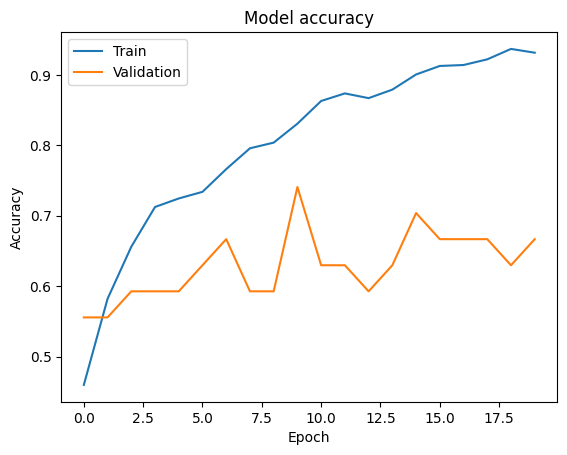

In [ ]:
plot_accuracy(history)

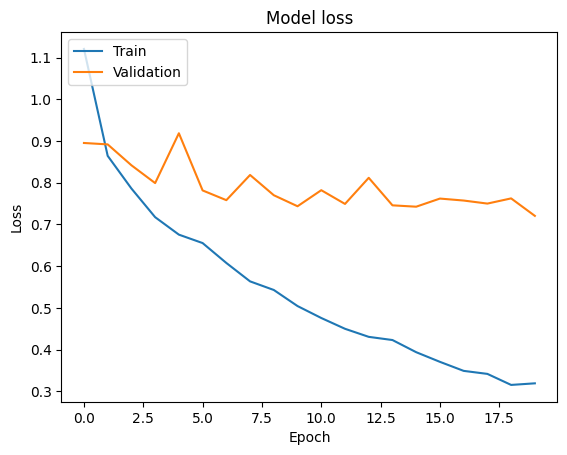

In [ ]:
plot_loss(history)

In [ ]:
model.evaluate(X_test_scaled, to_categorical(y_test))

1/1 [==============================] - 2s 2s/step - loss: 0.8108 - accuracy: 0.6207


[0.8107827305793762, 0.6206896305084229]

### Fine tuning example

In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=10)

# Fine tune the entire model
base_model.trainable = True
model.compile(optimizer=RMSprop(lr=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])
history_fine_tune = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=10)

NameError: ignored

In [ ]:
model.evaluate(X_test_scaled, to_categorical(y_test))

In [ ]:
plot_accuracy(history)

In [ ]:
plot_loss(history)

### CheXNet

In [ ]:
from keras.applications.densenet import DenseNet121

PATH_TO_CHEXNET_WEIGHTS = Path('/content/drive/MyDrive/osteoporosis_data/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

# base_model = DenseNet121(weights=None, include_top=False)
base_model = DenseNet121(weights=None,
                            include_top=False,
                            input_shape=(224, 224, 3))

predictions = Dense(14, activation='sigmoid', name='predictions')(base_model.output)
base_model = Model(inputs=base_model.input, outputs=predictions)
base_model.load_weights(PATH_TO_CHEXNET_WEIGHTS)


for layer in base_model.layers:
  layer.trainable = False
# base_model.trainable = True

base_model.layers.pop()

x = base_model.output
x = GlobalAveragePooling2D()(base_model.layers[-4].output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=20)

for layer in base_model.layers:
  layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=20)

Epoch 1/20
24/24 [==============================] - 33s 512ms/step - loss: 1.1656 - accuracy: 0.4180 - val_loss: 1.0214 - val_accuracy: 0.5556
Epoch 2/20
24/24 [==============================] - 6s 235ms/step - loss: 1.0521 - accuracy: 0.4772 - val_loss: 0.9747 - val_accuracy: 0.5185
Epoch 3/20
24/24 [==============================] - 6s 235ms/step - loss: 0.9715 - accuracy: 0.5323 - val_loss: 0.9781 - val_accuracy: 0.5185
Epoch 4/20
24/24 [==============================] - 6s 247ms/step - loss: 0.9606 - accuracy: 0.5282 - val_loss: 0.9553 - val_accuracy: 0.4074
Epoch 5/20
24/24 [==============================] - 5s 214ms/step - loss: 0.9562 - accuracy: 0.5067 - val_loss: 1.0152 - val_accuracy: 0.5185
Epoch 6/20
24/24 [==============================] - 6s 246ms/step - loss: 0.9980 - accuracy: 0.5094 - val_loss: 1.1476 - val_accuracy: 0.4444
Epoch 7/20
24/24 [==============================] - 5s 222ms/step - loss: 1.0677 - accuracy: 0.4812 - val_loss: 0.9905 - val_accuracy: 0.5185
Epoch

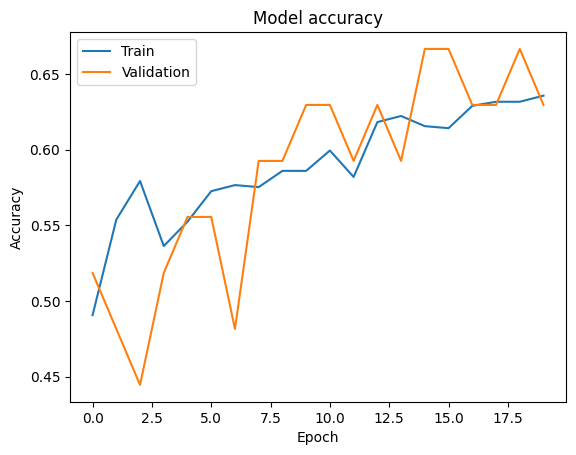

In [ ]:
plot_accuracy(history)

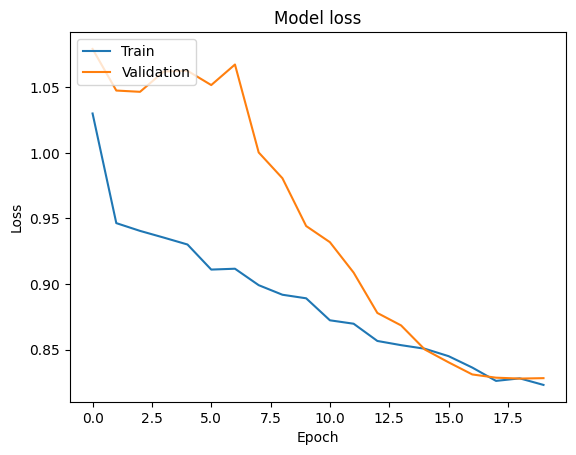

In [ ]:
plot_loss(history)

In [ ]:
model.evaluate(X_test_scaled, to_categorical(y_test))

1/1 [==============================] - 1s 807ms/step - loss: 0.7520 - accuracy: 0.6897


[0.7520198225975037, 0.6896551847457886]

### DenseNet

In [ ]:
# from tensorflow.keras.layers import Concatenate
# from tensorflow.keras.applications import ResNet50

# from tensorflow.keras.layers import Input
# input_layer = Input(shape=(224, 224, 1))
# rgb_input = Concatenate()([input_layer, input_layer, input_layer])
# ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_tensor=rgb_input)

# for layer in ResNet50_model.layers:
#     layer.trainable=False
from keras.applications.densenet import DenseNet121

PATH_TO_CHEXNET_WEIGHTS = Path('/content/drive/MyDrive/osteoporosis_data/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

# base_model = DenseNet121(weights=None, include_top=False)
base_model = DenseNet121(weights=None,
                            include_top=False,
                            input_shape=(224, 224, 3))

predictions = Dense(14, activation='sigmoid', name='predictions')(base_model.output)
base_model = Model(inputs=base_model.input, outputs=predictions)
base_model.load_weights(PATH_TO_CHEXNET_WEIGHTS)


for layer in base_model.layers:
  layer.trainable = False
# base_model.trainable = True

base_model.layers.pop()

In [ ]:
def build_model(layer, dense_model):
    last_layer = dense_model.get_layer(layer).output
    print(f'Last layer output shape: {last_layer.shape}')

    x = Flatten()(last_layer)
    x = Dense(512, activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dense(64, activation='relu')(x)
    # x = Dropout(0.5)(x)
    x = Dense(NUM_OF_CLASSES, activation='softmax')(x)

    model = Model(dense_model.input, x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = build_model('conv3_block3_concat', base_model)
history = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), verbose=1, epochs=20)

Last layer output shape: (None, 28, 28, 224)
Epoch 1/20
24/24 [==============================] - 4s 91ms/step - loss: 17.8874 - accuracy: 0.4301 - val_loss: 4.4746 - val_accuracy: 0.5556
Epoch 2/20
24/24 [==============================] - 2s 72ms/step - loss: 1.5349 - accuracy: 0.7003 - val_loss: 1.9986 - val_accuracy: 0.7407
Epoch 3/20
24/24 [==============================] - 2s 75ms/step - loss: 0.7301 - accuracy: 0.7930 - val_loss: 1.2686 - val_accuracy: 0.7037
Epoch 4/20
24/24 [==============================] - 2s 74ms/step - loss: 0.5441 - accuracy: 0.8306 - val_loss: 1.4334 - val_accuracy: 0.7037
Epoch 5/20
24/24 [==============================] - 2s 70ms/step - loss: 0.2494 - accuracy: 0.9086 - val_loss: 1.3392 - val_accuracy: 0.6296
Epoch 6/20
24/24 [==============================] - 2s 70ms/step - loss: 0.4333 - accuracy: 0.8844 - val_loss: 1.6890 - val_accuracy: 0.7037
Epoch 7/20
24/24 [==============================] - 2s 71ms/step - loss: 0.2875 - accuracy: 0.9126 - val_los

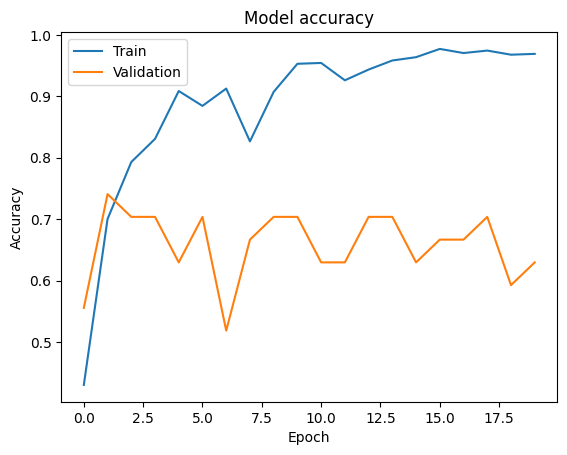

In [ ]:
plot_accuracy(history)

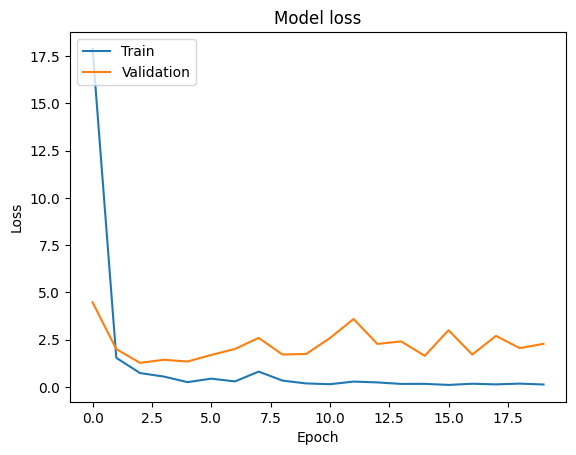

In [ ]:
plot_loss(history)

In [ ]:
for layer in base_model.layers[115:]:
	layer.trainable = True

In [ ]:
print("[INFO] re-compiling model...")
# opt = SGD(lr=1e-4, momentum=0.9)
opt = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=30)
model.evaluate(X_test_scaled, to_categorical(y_test))

[INFO] re-compiling model...
Epoch 1/30
24/24 [==============================] - 5s 106ms/step - loss: 2.5743 - accuracy: 0.7298 - val_loss: 4.7721 - val_accuracy: 0.7407
Epoch 2/30
24/24 [==============================] - 2s 73ms/step - loss: 0.5110 - accuracy: 0.8952 - val_loss: 3.4390 - val_accuracy: 0.7407
Epoch 3/30
24/24 [==============================] - 2s 69ms/step - loss: 0.3538 - accuracy: 0.9274 - val_loss: 3.7453 - val_accuracy: 0.4815
Epoch 4/30
24/24 [==============================] - 2s 69ms/step - loss: 0.2398 - accuracy: 0.9543 - val_loss: 2.3221 - val_accuracy: 0.6667
Epoch 5/30
24/24 [==============================] - 2s 70ms/step - loss: 0.2278 - accuracy: 0.9543 - val_loss: 2.7674 - val_accuracy: 0.7778
Epoch 6/30
24/24 [==============================] - 2s 70ms/step - loss: 0.2729 - accuracy: 0.9637 - val_loss: 2.0064 - val_accuracy: 0.7037
Epoch 7/30
24/24 [==============================] - 2s 68ms/step - loss: 0.2740 - accuracy: 0.9409 - val_loss: 3.0202 - val_

[6.732133865356445, 0.5517241358757019]

In [ ]:
model.evaluate(X_test_scaled, to_categorical(y_test))

1/1 [==============================] - 0s 81ms/step - loss: 6.7321 - accuracy: 0.5517


[6.732133865356445, 0.5517241358757019]

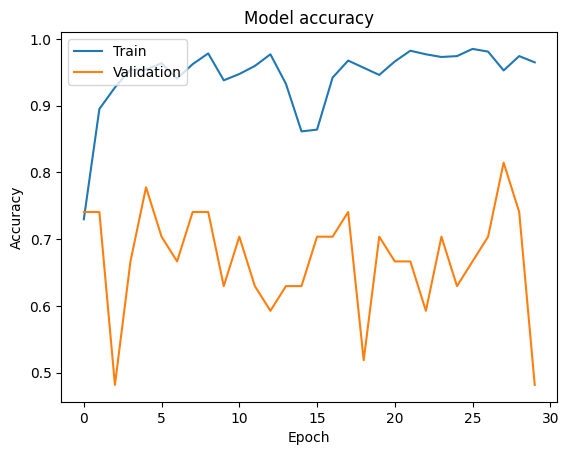

In [ ]:
plot_accuracy(H)

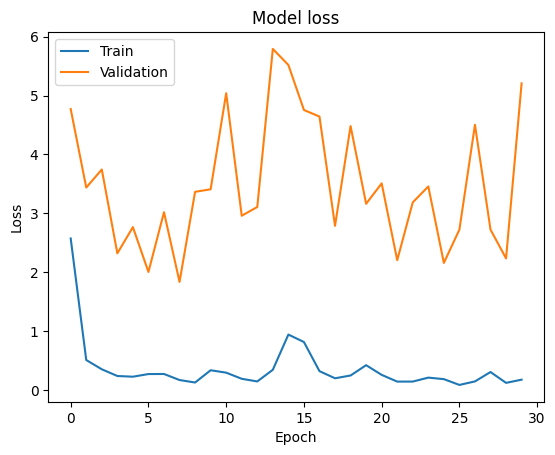

In [ ]:
plot_loss(H)

### YOLOv8

In [ ]:
!pip install keras-cv tensorflow keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
from keras.models import load_model

yolo_weights_path = Path('/content/drive/MyDrive/osteoporosis_data/yolov5x-seg.pt')

yolo_model = load_model(yolo_weights_path)

# for layer in model.layers:
#   layer.trainable = False

# model.classifier[6] = Dense(3, activation="softmax")

# model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
# history = model.fit(X_train_scaled, to_categorical(y_train), validation_data=(X_val_scaled, to_categorical(y_val)), epochs=20)

OSError: ignored

In [ ]:
plot_accuracy(history)

In [ ]:
plot_loss(history)